# Data Cleaning and Description
Tyler Christensen, William Lewis, Addison Powell, Jared Smith

## Dataset Descriptions
For our project, we intend to explore a few different branches. Each of these require their own dataset due to the nature of the project, though the methodology will remain largely the same. Our two main branches of exploration are:
- Sentiment Analysis of Casual Texts
    - For this we will use a dataset of over 1.6 million tweets, each labeled with a class related to its sentiment (negative, neutral, or positive).
- Sentiment Analysis of Reviews
    - For this we will use 2 datasets. The first is a set of yelp reviews from <a href="https://www.yelp.com/dataset/documentation/main">this link</a>. There are 1,250,000 reviews (we took a subset of the larger dataset of 6 million reviews out of concerns for memory), each labeled with a score out of 5 stars. The second is a set of 50,000 IMDb Movie reviews, each labeled with either a positive or negative sentiment.

## Validation Set
Before we began to look at the data in full, we sealed off 20% of each set to save for a final analysis. This was split via files, and as such we will not be able to access the validation sets unless we specifically load those files in our code. The split was chosen randomly and immediately saved into a separate file. We will reopen these and check our results towards the end of our project.

## Data Access
All the data can be found in <a href="https://drive.google.com/drive/folders/1Hp54gH3TQ93ELuzkHJI76C1nXsSI5CpE?usp=sharing">this Google Drive folder.</a>

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from html.parser import HTMLParser
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm
import pickle
import string
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import download
from itertools import compress

tqdm.pandas()
download('stopwords')

[nltk_data] Downloading package stopwords to /home/tylerc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Importing Data

In [119]:
# the directory that the data is stored in 
# don't store in git repo, please store it somewhere else on your computer
# data_dir = '../../data/'
data_dir = '/home/tylerc/dat/school/acme/'

# load the datasets
twitter_df = pd.read_csv(data_dir + "twitter_data.csv", index_col=0)
twitter_df.head()

,target,id,date,flag,user,text
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [120]:
imdb_df = pd.read_csv(data_dir + "imdb_data.csv", index_col=0)
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive


In [121]:
yelp_df = pd.read_csv(data_dir + "yelp_data.csv", index_col=0)
yelp_df.head()

,user_id,business_id,stars,useful,funny,cool,date,text
477697,5sHSDjYnNkaia5lUec7rNw,ZSJeZPEoHXMdgMpRIMBpiQ,5.0,2,1,2,We have been visiting the Devon Horse Show for...,2019-05-30 14:18:56
757770,4dwF1g0wOZjwjxyQ8cRVoA,AjQGanUkM-SFa7MxwTfMRw,5.0,2,0,1,"What an amazing, random Friday adventure. I re...",2019-06-21 23:14:42
1013355,NyPaks2v8GkcWVsCXctpKA,G8r_HHphWNWfRN0LgVwrFA,1.0,0,0,0,Last three items broke- they wouldn't return t...,2011-11-14 01:10:28
98618,gpzgC3AwKY7cLkMsdSNA3w,2kuhZOrWcLYe_XePccr4lA,4.0,0,0,0,Delicious. We got Chicago style. Nice place. O...,2018-03-19 00:28:12
446665,Iu1akOzyVihFr7oj9JnK1Q,dvNNkfCyAjOq1HHltSRXRA,5.0,0,0,0,"Great experience, Roman is the best, he went b...",2016-04-15 17:24:36


## Data Transformation
Due to the size and time constraints from our local machines, we will perform the data transformation on a subset of the twitter data of 10,000 samples. However, the process will be the same for the entire dataset.

Since we are treating each sequence of data as 'time series' data, the transformation process requires a few steps.
- Clean the data of punctuation, numbers, urls, and html tags. We also removed stop words (words that are so widely used that they contain no useful information)
- Create a large corpus of unique words found in the dataset.
- Iterate through each word in each sequence and replace it with the index in the corpus. 

As an additional note, the `remove_stopwords` function also performs lemmatization. This means words like 'quiet', 'quietly', and 'quieter' are all set to 'quiet', their root form.

#### Example
As an example, assume our data is the following two rows:<br>
```
["Hey, I was curious about why you would even think that @Wendys?",
"Just saw @Dune. I think it was pretty good. What about you?"]
```
The first step would transform the data like so:<br>
```
[['hey', 'i', 'was', 'curious', 'about', 'why', 'you', 'would', 'even', 'think', 'that', 'wendys'],
 ['just', 'saw', 'dune', 'i', 'think', 'it', 'was', 'pretty', 'good', 'what', 'about', 'you']]
```
Then, we create a set of unique words:
```
['hey', 'i', 'was', 'curious', 'about', 'why', 
 'you', 'would', 'even', 'think', 'that', 'wendys',
'just', 'saw', 'dune', 'it', 'was', 'pretty', 
 'good', 'what']
```
Last, we replace the transformed data with the indices of the words in the corpus, giving us our ordered sequence of data.
```
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [12, 13, 14, 1, 9, 15, 16, 17, 18, 19, 4, 6]]
```


In [122]:
# Removes punctuation and numbers (by character) and returns as a single string
def remove_punctuation(text):
    return ''.join([char for char in text if (char not in string.punctuation) and (not char.isdigit())])

# Remove URLs from a string
def remove_urls(text, replacement_text=""):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(replacement_text, text)

# Remove HTML from a string
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()
def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

# Splits the message on one or more non-word character
# Returns as a list
def tokenize(text):
    return re.split("\W+", text)
    
# Define stopwords and remove them from the list
# Also reduce words to the root word
def remove_stopwords(text):
    stopword_lst = stopwords.words('english')
    stopword_lst.append("")
    ps = PorterStemmer()
    words = [ps.stem(word) for word in text if word not in stopword_lst]
    return words

<>:30: SyntaxWarning: invalid escape sequence '\W'
<>:30: SyntaxWarning: invalid escape sequence '\W'
/tmp/ipykernel_5670/1477077293.py:30: SyntaxWarning: invalid escape sequence '\W'
  return re.split("\W+", text)


In [123]:
# Apply cleaning functions to the data
twitter_subset = twitter_df.sample(10000)
clean_data = twitter_subset['text'].progress_apply(lambda x: remove_stopwords(   # Remove stopwords and shorten to root words
                                                tokenize(           # Split message into a list
                                                remove_punctuation( # Remove punctuation and numbers
                                                remove_urls(        # Remove URLs
                                                strip_tags(x)       # Remove HTML tags
                                                )).lower())))

100%|██████████| 10000/10000 [00:01<00:00, 5746.80it/s]


In [124]:
# Turn each mesage into a sequence of unique indices
#   that correspond to a given word
loop = tqdm(total=len(clean_data), position=0, leave=False)

words = []
for message in clean_data:
    words = list(set(words + message))
    loop.update()

100%|█████████▉| 9982/10000 [00:03<00:00, 1806.62it/s] 

In [125]:
seq_data = [[words.index(word) for word in message] for message in clean_data]

In [126]:
i = np.random.randint(low=0, high=len(seq_data))
print("Before/After Transformation:")
print(twitter_subset.iloc[i]['text'])
print(f"{clean_data.iloc[i]}")
print(f"{seq_data[i]}")

Before/After Transformation:
@Maggie_too No. I'm dreaming of home.....  Come hell or high water, I will get there!
['maggietoo', 'im', 'dream', 'home', 'come', 'hell', 'high', 'water', 'get']
[10451, 14514, 12556, 12680, 12565, 3374, 14674, 376, 2876]


## Get Experimental Dataset

In [127]:
twitter_subset['cleaned_data'] = seq_data
twitter_subset = twitter_subset.reset_index()
twitter_subset = twitter_subset.drop(columns=['text', 'flag', 'index'])

In [130]:
to_dump = {}
to_dump['data'] = twitter_subset
to_dump['dictionary'] = words

# dump
with open("small_data.pkl", "wb") as f:
    pickle.dump(to_dump, f)

## Feature Analysis
Due to the simple nature of our dataset, the only features that are required to perform the base analysis is the text and target class. However, with the Yelp dataset we can potentially do some deeper analyses. For example, we can create a model specific to one business or reviewer and see if we can be more accurate with our predicions. 

Due to the sources of our datasets, there were no missing values and thus no need for imputation. As all of our targets are classifciation, there is no need for anything like normalization of our data. Therefore, feature engineering starts and ends with the transformation of the data.


## Data Visualizations and Analysis
The distribution of words used should follow the Zipf distribution, even with a smaller lexicon of keywords that exclude things such as particles. See this paper for a Zipf distribution on a X (formerly known as twitter) dataset: https://www.researchgate.net/figure/Zipf-distribution-of-Twitter-keywords-at-different-spatial-levels_fig1_311857596

One thing we expect to see is a binomial distribution heavily weighted to the negative sentiment for a good/bad sentiment analysis (most people on X (formerly known as twitter) are negative).  
If we have pairs of either/or states such as a good/bad sentiment or a funny/serious sentiment we can make predictions on a correlation matrix.  Some visualiztions include identifying keywords and creating a heatmap of the intensity with which they correspond to our hidden states.  Other visualiztions could include lists of words or sentence fragements that correspond the most to certain sentiments

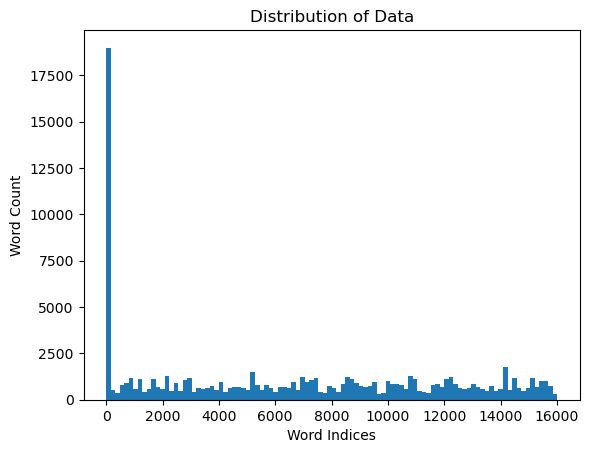

In [ ]:
combined = [x for idx in seq_data for x in idx]
plt.hist(combined, bins=100)
plt.xlabel('Word Indices')
plt.ylabel('Word Count')
plt.title('Distribution of Data')
plt.show()

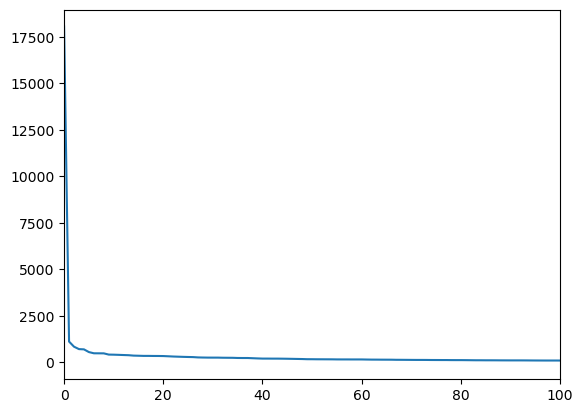

''

In [ ]:
unq, counts = np.unique(combined, return_counts=True)
plt.plot(np.sort(counts)[::-1])
plt.xlim([0,100])
plt.show()

This does not seem to follow the Zipf distribution as described above. This will take more analysis to ensure the transformation of our data is correct.

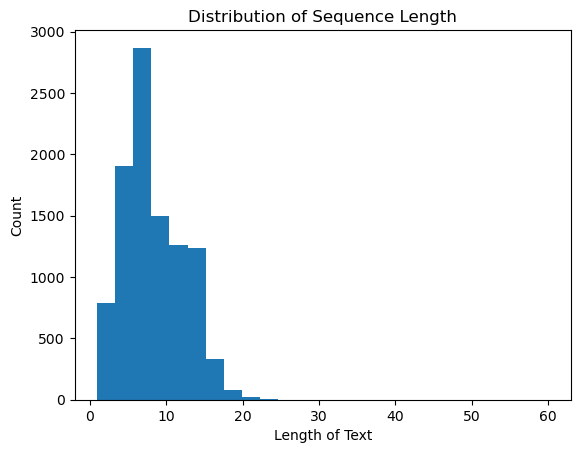

In [ ]:
# plot length of sequences
lens = np.array([len(msg) for msg in seq_data])
plt.hist(lens, bins=25)
plt.xlabel("Length of Text")
plt.ylabel("Count")
plt.title("Distribution of Sequence Length")
plt.show()

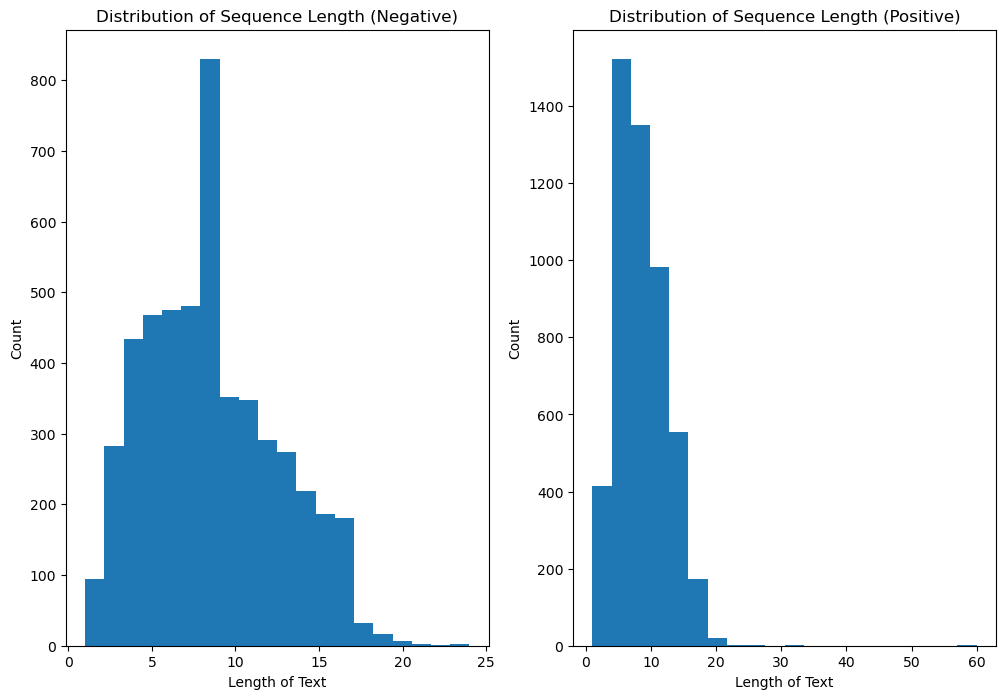

In [ ]:
# get a mask for negative/positive sentiment
mask_0 = (twitter_subset['target'] == 0).tolist()
mask_1 = (twitter_subset['target'] == 4).tolist()

# plot positive vs length
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.hist(lens[mask_0], bins=20)
plt.xlabel("Length of Text")
plt.ylabel("Count")
plt.title("Distribution of Sequence Length (Negative)")

plt.subplot(122)
plt.hist(lens[mask_1], bins=20)
plt.xlabel("Length of Text")
plt.ylabel("Count")
plt.title("Distribution of Sequence Length (Positive)")

plt.show()

We see above that there is an outlier at length > 100. Removing it we can get a better look at how the distributions compare.

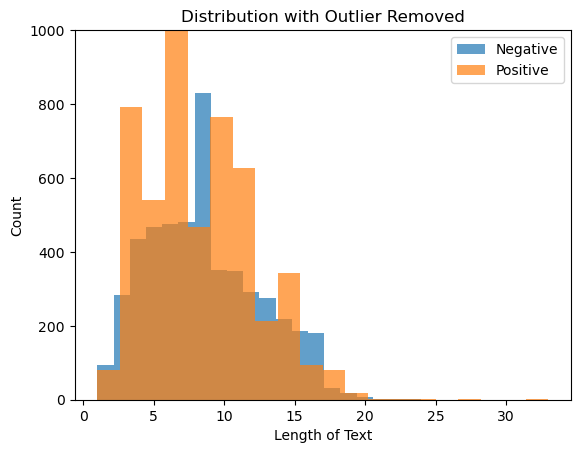

In [ ]:
lens_out = np.delete(lens[mask_1], np.where(lens[mask_1]==max(lens)))

# plot positive vs length
plt.hist(lens[mask_0], bins=20, alpha=0.7, label="Negative")
plt.xlabel("Length of Text")
plt.ylabel("Count")
plt.ylim(0, 1000)

# plt.subplot(122)
plt.hist(lens_out, bins=20, alpha=0.7, label="Positive")
plt.ylim(0, 1000)
plt.xlabel("Length of Text")
plt.ylabel("Count")

plt.title("Distribution with Outlier Removed")
plt.legend()
plt.show()

As the distributions seem similar, we can safely assume that tweet length has no correlation with sentiment.

Next, we look at how often certain words appear in negative vs positive text.

In [ ]:
seq_neg, seq_pos = list(compress(seq_data, mask_0)), list(compress(seq_data, mask_1))
com_neg, com_pos = [x for idx in seq_neg for x in idx], [x for idx in seq_pos for x in idx]

# get unique and counts
neg_uq, nucnt = np.unique(com_neg, return_counts=True)
pos_uq, pucnt = np.unique(com_pos, return_counts=True)

neg_uq, nucnt, pos_uq, pucnt = neg_uq[1:], nucnt[1:], pos_uq[1:], pucnt[1:]

# sort and get top words
n_idx = np.argsort(nucnt)[::-1]
p_idx = np.argsort(pucnt)[::-1]

print("Highest Occuring Negative Words")
for w in neg_uq[n_idx][:5]:
    print("   ",words[w])
print()

print("Highest Occuring Positive Words")
for w in pos_uq[p_idx][:5]:
    print("   ", words[w])


plot_w = [3539, 6275, 4406, 14354, 5184]


Highest Occuring Negative Words
    im
    go
    get
    work
    miss

Highest Occuring Positive Words
    im
    love
    good
    go
    day


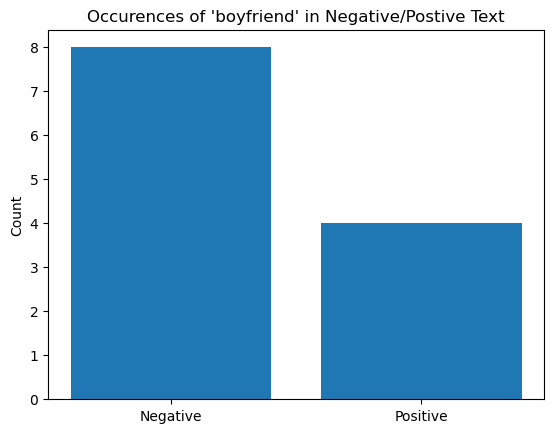

ValueError: can only convert an array of size 1 to a Python scalar

100%|██████████| 10000/10000 [00:18<00:00, 1793.52it/s]

In [ ]:
for word in plot_w:
    text_w = words[word]
    neg_count = nucnt[np.where(neg_uq==word)].item()
    pos_count = pucnt[np.where(pos_uq==word)].item()

    plt.bar([0, 1], [neg_count, pos_count])
    plt.title(f"Occurences of '{text_w}' in Negative/Postive Text")
    plt.xticks(ticks=[0,1], labels=["Negative", "Positive"])
    plt.ylabel("Count")
    plt.show()

We see above that there are some words, like 'i'm', that are frequently used in both negative and positive statements. However, there are also plenty of words that fall mainly into one or the other. Thus we can reasonably and safely assume that there is a correlation between certain words and the sentiment. Going ahead with this assumption will give us confidence that we can achieve significant results.

## Conclusions
Our initial idea was to use models like HMM and Kalman Filters to estimate the motive behind written casual text, specifically the emotion the author intended to convey. However, due to the difficulty of determining an appropriate way to measure success, and after exploring our data, that goal is difficult to achieve in full. Instead, these datasets will allow use to explore how an HMM would instead interpret the hidden states that drive these sequences of text. Unfortunately, this is more of an exploratory goal.

In order to utilize more accessible measures of success, the HMM could be trained on labeled data to classify text into predefined sentiment categories. We could then anaylze the trained model and see if its parameters could give us insight to the intent behind the text.